In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

In [34]:
import nlopt
import autograd.numpy as np
import autograd
import flux_center

In [3]:
def penalty(x):
    return sum(x*(1-x))

def grad_penalty(x):
    return (1 - 2 * x)
    
    
def thresholding(x, eta=0.5, beta = 1):
    return (np.tanh(eta*beta) + np.tanh((x - eta)*beta))/(np.tanh(eta*beta) + np.tanh((1 - eta)*beta))

grad_thresholding = autograd.elementwise_grad(thresholding)

def optimization_withthresholdingNpenalty(x1, coefpenalty=0., beta = 1, eta = 0.2, debug=False):
    trajectory = []

    while not np.all(np.isclose( 1.*(thresholding(x1, eta=eta, beta=beta)>eta), thresholding(x1, eta=eta, beta=eta),atol=1e-01)):
        if debug:
            print("beta=", beta)
        def myfunc(x, grad, debug=debug):
        #     print(thresholding(x, eta=eta, beta=beta))
            flux, gradval = flux_center.center_flux_normalized_grad(np.reshape(thresholding(x, eta=eta, beta=beta),(1, 25)))
            gradval = gradval*grad_thresholding(x, eta=eta, beta=beta)  - grad_thresholding(x, eta=eta, beta=beta)*grad_penalty(thresholding(x, eta=eta, beta=beta))*coefpenalty
            if grad.size > 0:
                grad[:] = np.ravel(gradval[:]).tolist() #to avoid different type returned
                if debug:
                    print(flux, ",")
                trajectory.append(flux)
            return flux-penalty(thresholding(x))*coefpenalty
        opt = nlopt.opt(nlopt.LD_MMA, 25)
        opt.set_lower_bounds(np.zeros(25))
        opt.set_upper_bounds(np.ones(25))
        opt.set_max_objective(myfunc)
        opt.set_xtol_rel(1e-3)
        opt.set_ftol_rel(1e-3)
        x = opt.optimize(x1)
        maxf = opt.last_optimum_value()
        if np.all(np.isclose(thresholding(x1, eta=eta, beta=beta), thresholding(x, eta=eta, beta=beta))) or beta>2^16:
            return x, beta, trajectory
        else:
            x1 = x
        beta = 2*beta
    return x1, beta, trajectory
        

In [4]:
x0 = np.random.rand(25)
x0

array([0.0889743 , 0.42738968, 0.87783954, 0.23952464, 0.93311497,
       0.48497023, 0.2272896 , 0.52952177, 0.98148194, 0.69334115,
       0.37235015, 0.85415202, 0.91146617, 0.4648216 , 0.65196218,
       0.39024344, 0.44161757, 0.72846072, 0.07791953, 0.78242183,
       0.13086544, 0.53609705, 0.14088034, 0.4873372 , 0.73275151])

In [5]:
flux_center.center_flux_normalized_grad(x0)

(0.29394550771125705,
 array([ 0.03584578,  0.05110718,  0.02688598,  0.01496526,  0.08804792,
         0.03154793, -0.00099007,  0.08110772,  0.03319638,  0.0231407 ,
         0.03106965,  0.03068958, -0.7317209 ,  0.01523443,  0.00204714,
         0.01676153,  0.00144068,  0.04507051, -0.02088084, -0.00762234,
         0.00474189,  0.02380093,  0.05536612,  0.02688134, -0.01508206],
       dtype=float32))

In [6]:
def fd_grad(f, p):
    delta = 1e-2
    grad = []
    perturb = p * 0.
    for i in range(len(p)):
        perturb[i] += delta
        grad.append((f(p+perturb)-f(p-perturb))/2/delta)
        perturb[i] -= delta
    return grad

In [7]:
fdgrad = fd_grad(lambda x: flux_center.center_flux_normalized_grad(x)[0], x0)

In [8]:
fdgrad

[0.03604089581390191,
 0.050910084739980155,
 0.02724963726472296,
 0.015170624391089294,
 0.08683775823254691,
 0.02942308052355791,
 -0.0013445466763489788,
 0.08053826147621235,
 0.03323895738558125,
 0.02466909788231275,
 0.030827598776317355,
 0.029703523351501393,
 -0.7323491268950183,
 0.015309554532014213,
 0.003989141078872271,
 0.015883184498477476,
 0.002245742112416682,
 0.045127917331266865,
 -0.022112457556655585,
 -0.009059024107246905,
 0.004876131656450511,
 0.01819206133054363,
 0.047518426129317115,
 0.024411283020642216,
 -0.012717806000361875]

In [9]:
# x1, beta, traj = optimization_withthresholdingNpenalty(x0, coefpenalty=1/25)

In [10]:
# optimum = thresholding(x1, eta=eta, beta=beta)
# optimum

In [11]:
# flux_center.center_flux_normalized_grad(optimum)

In [12]:
# binarized = 1.*(thresholding(x1, eta=eta, beta=beta)>eta)
# binarized

In [13]:
# flux_center.center_flux_normalized_grad(binarized)

In [14]:
def summaryopt(x0, coefpenalty=0., beta = 1, eta = 0.2):
    x1, beta, traj = optimization_withthresholdingNpenalty(x0, coefpenalty=coefpenalty, beta=beta, eta=eta)
    optimum = thresholding(x1, eta=eta, beta=beta)
    print(flux_center.center_flux_normalized_grad(optimum)[0])
    binarized = 1.*(thresholding(x1, eta=eta, beta=beta)>eta)
    endval = flux_center.center_flux_normalized_grad(binarized)[0]
    print(endval, binarized)
    return endval, x1, optimum, binarized, traj

In [52]:
x0 = np.random.rand(25)

endval, x1, optimum, binarized, traj0 = summaryopt(x0)
print(len(traj0))
print(flux_center.center_flux_normalized(binarized))
traj0.append(flux_center.center_flux_normalized(binarized))

2.2668049682852236
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
34
2.446877816517786


In [74]:
x2 = np.random.rand(25)

endval, x1, optimum, binarized, traj2 = summaryopt(x2)
print(len(traj2))
print(flux_center.center_flux_normalized(binarized))
traj2.append(flux_center.center_flux_normalized(binarized))

2.266943159344508
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
34
2.446877816517786


In [75]:
x3 = np.random.rand(25)

endval, x1, optimum, binarized, traj3 = summaryopt(x3)
print(len(traj3))
print(flux_center.center_flux_normalized(binarized))
traj3.append(flux_center.center_flux_normalized(binarized))

2.013043064715399
1.9585416202187607 [0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0.]
67
2.111239209629362


In [38]:
x4 = np.random.rand(25)

endval, x1, optimum, binarized, traj4 = summaryopt(x4)
print(len(traj4))
print(flux_center.center_flux_normalized(binarized))
traj4.append(flux_center.center_flux_normalized(binarized))

2.272491220252499
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
34
2.446877816517786


In [71]:
x5 = np.random.rand(25)

endval, x1, optimum, binarized, traj5 = summaryopt(x5)
print(len(traj5))
print(flux_center.center_flux_normalized(binarized))
traj5.append(flux_center.center_flux_normalized(binarized))

2.275708540182546
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
34
2.446877816517786


In [20]:
x6 = np.random.rand(25)

endval, x1, optimum, binarized, traj6 = summaryopt(x6)
print(len(traj6))
print(flux_center.center_flux_normalized(binarized))
traj6.append(flux_center.center_flux_normalized(binarized))

2.24541817093486
2.245363455250344 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
29
2.43466232370736


In [40]:
x7 = np.random.rand(25)

endval, x1, optimum, binarized, traj7 = summaryopt(x7)
print(len(traj7))
print(flux_center.center_flux_normalized(binarized))
traj7.append(flux_center.center_flux_normalized(binarized))

2.27252045428052
2.245363455250344 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
30
2.43466232370736


In [76]:
x8 = np.random.rand(25)

endval, x1, optimum, binarized, traj8 = summaryopt(x8)
print(len(traj8))
print(flux_center.center_flux_normalized(binarized))
traj8.append(flux_center.center_flux_normalized(binarized))

2.266905685729875
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
27
2.446877816517786


In [57]:
x9 = np.random.rand(25)

endval, x1, optimum, binarized, traj9 = summaryopt(x9)
print(len(traj9))
print(flux_center.center_flux_normalized(binarized))
traj9.append(flux_center.center_flux_normalized(binarized))

2.266796456604001
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
32
2.446877816517786


In [77]:
x10 = np.random.rand(25)

endval, x1, optimum, binarized, traj10 = summaryopt(x10)
print(len(traj10))
print(flux_center.center_flux_normalized(binarized))
traj10.append(flux_center.center_flux_normalized(binarized))

2.2727874966191743
2.2667444110626014 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
39
2.446877816517786


(0.0, 30.0, 0.0, 2.5)

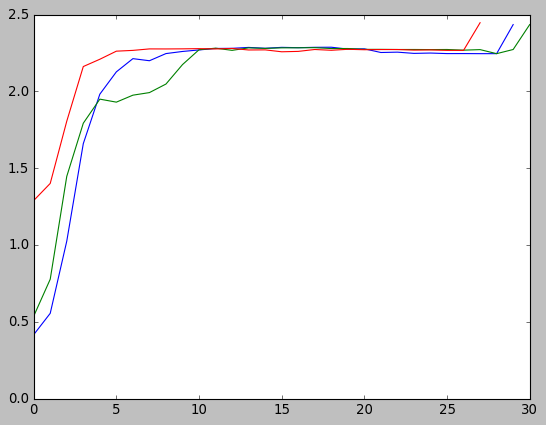

In [78]:

plt.plot(traj6)
plt.plot(traj7)
plt.plot(traj8)
plt.axis("on")

In [79]:
import numpy as np

fname = "optimizationcurve_fig8_3.txt"

A = [
traj6,
traj7,
traj8]

le = []
for li in A:
    le.append((len(li)))

mv = np.max(le)

Ar = []
for li in A:
    temp = np.ones(mv) * li[-1]
    temp[:len(li)] = li
    Ar.append(temp)

Arf = np.reshape(Ar,(len(A),-1))

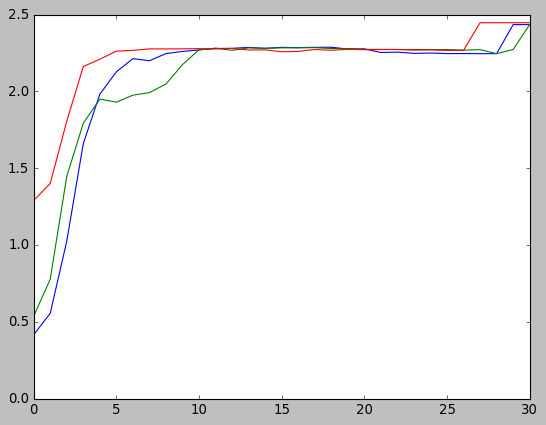

In [80]:
plt.plot(np.transpose(Arf))

In [81]:
np.savetxt(fname, Arf, delimiter=',')